<a href="https://colab.research.google.com/github/ZPKey/CS598-Final-Project/blob/main/Project_Report_Code_CS598.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import defaultdict
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# ---- Fine → Coarse label mapping
fine_to_coarse = [
    4, 1, 14, 8, 0, 6, 7, 7, 18, 3, 3, 14, 9, 18, 7, 11, 3, 9, 7, 11,
    6, 11, 5, 10, 7, 6, 13, 15, 3, 15, 0, 11, 1, 10, 12, 14, 16, 9, 11, 5,
    5, 19, 8, 8, 15, 13, 14, 17, 18, 10, 16, 4, 17, 4, 2, 0, 17, 4, 18, 17,
    10, 3, 2, 12, 12, 16, 12, 1, 9, 19, 2, 10, 0, 1, 16, 12, 9, 13, 15, 13,
    16, 19, 2, 4, 6, 19, 5, 5, 8, 19, 18, 1, 2, 6, 15, 13, 19, 17, 1, 8
]

class CIFAR100Coarse(torchvision.datasets.CIFAR100):
    def __getitem__(self, index):
        img, fine_label = super().__getitem__(index)
        coarse_label = fine_to_coarse[fine_label]
        return img, coarse_label

# ---- Data transforms and loaders
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409),
                         (0.2673, 0.2564, 0.2762))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409),
                         (0.2673, 0.2564, 0.2762))
])

trainset = CIFAR100Coarse(root='./data', train=True, download=True, transform=transform_train)
testset = CIFAR100Coarse(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0, pin_memory=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)

100%|██████████| 169M/169M [00:13<00:00, 12.7MB/s]


In [ ]:
class ResNeXtBottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, cardinality, bottleneck_width, stride):
        super().__init__()
        D = cardinality * bottleneck_width
        self.conv_reduce = nn.Conv2d(in_channels, D, 1, bias=False)
        self.bn_reduce = nn.BatchNorm2d(D)
        self.conv_conv = nn.Conv2d(D, D, 3, stride, 1, groups=cardinality, bias=False)
        self.bn = nn.BatchNorm2d(D)
        self.conv_expand = nn.Conv2d(D, D * self.expansion, 1, bias=False)
        self.bn_expand = nn.BatchNorm2d(D * self.expansion)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * D:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * D, 1, stride, bias=False),
                nn.BatchNorm2d(self.expansion * D)
            )

    def forward(self, x):
        out = torch.relu(self.bn_reduce(self.conv_reduce(x)))
        out = torch.relu(self.bn(self.conv_conv(out)))
        out = self.bn_expand(self.conv_expand(out))
        out += self.shortcut(x)
        return torch.relu(out)

In [ ]:
class ResNeXt(nn.Module):
    def __init__(self, cardinality=8, depth=29, bottleneck_width=64, num_classes=20):
        super().__init__()
        layers = (depth - 2) // 9
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.stage1 = self._make_stage(layers, 1)
        self.stage2 = self._make_stage(layers, 2)
        self.stage3 = self._make_stage(layers, 2)
        self.classifier = nn.Linear(self.in_channels, num_classes)

    def _make_stage(self, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        stage = []
        for s in strides:
            stage.append(ResNeXtBottleneck(self.in_channels, self.cardinality, self.bottleneck_width, s))
            self.in_channels = ResNeXtBottleneck.expansion * self.cardinality * self.bottleneck_width
        return nn.Sequential(*stage)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = torch.nn.functional.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


In [ ]:
class BasicBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, cardinality, bottleneck_width, stride, use_grouped=True):
        super().__init__()
        D = cardinality * bottleneck_width
        groups = cardinality if use_grouped else 1

        self.conv_reduce = nn.Conv2d(in_channels, D, kernel_size=1, bias=False)
        self.bn_reduce = nn.BatchNorm2d(D)

        self.conv_conv = nn.Conv2d(D, D, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False)
        self.bn = nn.BatchNorm2d(D)

        self.conv_expand = nn.Conv2d(D, D * self.expansion, kernel_size=1, bias=False)
        self.bn_expand = nn.BatchNorm2d(D * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * D:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * D, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * D)
            )

    def forward(self, x):
        out = torch.relu(self.bn_reduce(self.conv_reduce(x)))
        out = torch.relu(self.bn(self.conv_conv(out)))
        out = self.bn_expand(self.conv_expand(out))
        out += self.shortcut(x)
        return torch.relu(out)

In [ ]:
class ResNetVariant(nn.Module):
    def __init__(self, depth, cardinality, bottleneck_width, num_classes=20, use_grouped=True):
        super().__init__()
        layers = (depth - 2) // 9
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_channels = 64
        self.use_grouped = use_grouped

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.stage1 = self._make_stage(layers, stride=1)
        self.stage2 = self._make_stage(layers, stride=2)
        self.stage3 = self._make_stage(layers, stride=2)

        self.classifier = nn.Linear(self.in_channels, num_classes)

    def _make_stage(self, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        blocks = []
        for s in strides:
            block = BasicBottleneck(
                self.in_channels,
                self.cardinality,
                self.bottleneck_width,
                stride=s,
                use_grouped=self.use_grouped
            )
            blocks.append(block)
            self.in_channels = block.expansion * self.cardinality * self.bottleneck_width
        return nn.Sequential(*blocks)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = torch.nn.functional.adaptive_avg_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [ ]:
def evaluate_hidden_stratification(model, dataloader, device):
    model.eval()
    subclass_correct = defaultdict(int)
    subclass_total = defaultdict(int)
    superclass_correct = defaultdict(int)
    superclass_total = defaultdict(int)
    fine_targets = torchvision.datasets.CIFAR100(root='./data', train=False, download=False).targets

    with torch.no_grad():
        for i, (images, _) in enumerate(dataloader):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            for j in range(images.size(0)):
                idx = i * dataloader.batch_size + j
                fine_label = fine_targets[idx]
                coarse_label = fine_to_coarse[fine_label]
                pred = predicted[j].item()

                subclass_total[fine_label] += 1
                superclass_total[coarse_label] += 1
                if pred == coarse_label:
                    subclass_correct[fine_label] += 1
                    superclass_correct[coarse_label] += 1

    print("\n=== Schema Completion (Hidden Stratification) ===")
    for sc in range(20):
        diffs = []
        for fine in [i for i in range(100) if fine_to_coarse[i] == sc]:
            if subclass_total[fine] == 0:
                continue
            acc = subclass_correct[fine] / subclass_total[fine]
            sc_acc = superclass_correct[sc] / superclass_total[sc]
            diffs.append(acc - sc_acc)
        if diffs:
            print(f"Superclass {sc:2d}: Δacc range [{min(diffs):+.3f}, {max(diffs):+.3f}]")
    return subclass_correct, subclass_total, superclass_correct, superclass_total


In [ ]:
def train_model(model, trainloader, testloader, device, epochs=10):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = MultiStepLR(optimizer, milestones=[150, 225], gamma=0.1)
    scaler = GradScaler()
    best_acc = 0.0

    #training
    for epoch in range(epochs):
        model.train()
        correct = total = 0
        for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100. * correct / total
        print(f"Train Acc: {acc:.2f}%")

        # evaluation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast():
                    outputs = model(inputs)
                    _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_acc = 100. * correct / total
        print(f"Test Acc: {test_acc:.2f}%")

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("✔️ Best model saved.")

        scheduler.step()

# ---- Start training
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#used to put items into their superclasses
coarse_label_names = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables',
    'household electrical devices', 'household furniture', 'insects', 'large carnivores',
    'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles',
    'small mammals', 'trees', 'vehicles 1', 'vehicles 2'
]

In [ ]:
def plot_hidden_stratification_absolute_accuracy(
    subclass_correct,
    subclass_total,
    fine_to_coarse,
    coarse_label_names
):
    stratification = defaultdict(list)

    for fine_label in range(100):
        coarse_label = fine_to_coarse[fine_label]
        if subclass_total[fine_label] == 0:
            continue

        subclass_acc = subclass_correct[fine_label] / subclass_total[fine_label]
        stratification[coarse_label].append(subclass_acc)

    # Plot
    plt.figure(figsize=(14, 6))
    for coarse_idx in sorted(stratification.keys()):
        x_vals = [coarse_label_names[coarse_idx]] * len(stratification[coarse_idx])
        y_vals = stratification[coarse_idx]
        plt.scatter(x_vals, y_vals, alpha=0.7)

    plt.ylim(0.0, 1.0)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Superclass (Coarse Label)")
    plt.ylabel("Accuracy")
    plt.title("Hidden Stratification: Subclass Accuracy by Superclass")
    plt.axhline(0.5, color='gray', linestyle='--', linewidth=0.7)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
def benchmark_model_variant_for_hidden_stratification_plot(
    model,
    model_name: str,
    trainloader,
    testloader,
    device,
    fine_to_coarse,
    coarse_label_names,
    epochs=10
):
    print(f"\n🚀 Benchmarking {model_name}")
    train_model(model, trainloader, testloader, device, epochs=epochs)  # assumes AMP-enabled loop

    # Run stratification evaluation
    subclass_correct, subclass_total, superclass_correct, superclass_total = evaluate_hidden_stratification(
        model, testloader, device
    )

    # Compute schema completion accuracy (coarse label prediction correctness over all samples)
    total_correct = sum(subclass_correct.values())
    total_samples = sum(subclass_total.values())
    schema_acc = 100.0 * total_correct / total_samples

    # Compute deltas (subclass - superclass) for plotting
    stratification = defaultdict(list)
    all_deltas = []
    for fine_label in range(100):
        coarse_label = fine_to_coarse[fine_label]
        if subclass_total[fine_label] == 0 or superclass_total[coarse_label] == 0:
            continue

        subclass_acc = subclass_correct[fine_label] / subclass_total[fine_label]
        superclass_acc = superclass_correct[coarse_label] / superclass_total[coarse_label]
        delta = subclass_acc - superclass_acc
        stratification[coarse_label].append(delta)
        all_deltas.append(delta)

    # Metrics
    mean_delta = sum(map(abs, all_deltas)) / len(all_deltas)
    max_delta = max(map(abs, all_deltas))
    min_delta = min(map(abs, all_deltas))

    # Report
    print(f"\n📊 Results for {model_name}:")
    print(f" - Schema Completion Accuracy: {schema_acc:.2f}%")
    print(f" - Mean Δ Accuracy: {mean_delta:.4f}")
    print(f" - Max |Δ Accuracy|: {max_delta:.4f}")
    print(f" - Min |Δ Accuracy|: {min_delta:.4f}")

    # Plot with provided function
    plot_hidden_stratification_absolute_accuracy(
        subclass_correct,
        subclass_total,
        fine_to_coarse,
        coarse_label_names
    )

    return {
        'model': model_name,
        'schema_acc': schema_acc,
        'mean_delta': mean_delta,
        'max_delta': max_delta,
        'min_delta': min_delta
    }

<ipython-input-8-4a9f26562980>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



🚀 Benchmarking ResNeXt-29 8×64d


Epoch 1/25:   0%|          | 0/782 [00:00<?, ?it/s]<ipython-input-8-4a9f26562980>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/25: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s]
<ipython-input-8-4a9f26562980>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Acc: 9.42%
Test Acc: 12.43%
✔️ Best model saved.


Epoch 2/25: 100%|██████████| 782/782 [05:12<00:00,  2.50it/s]


Train Acc: 14.95%
Test Acc: 16.03%
✔️ Best model saved.


Epoch 3/25: 100%|██████████| 782/782 [05:14<00:00,  2.48it/s]


Train Acc: 20.19%
Test Acc: 23.10%
✔️ Best model saved.


Epoch 4/25: 100%|██████████| 782/782 [05:17<00:00,  2.47it/s]


Train Acc: 23.95%
Test Acc: 26.26%
✔️ Best model saved.


Epoch 5/25: 100%|██████████| 782/782 [05:17<00:00,  2.47it/s]


Train Acc: 27.46%
Test Acc: 25.41%


Epoch 6/25: 100%|██████████| 782/782 [05:17<00:00,  2.46it/s]


Train Acc: 31.17%
Test Acc: 31.07%
✔️ Best model saved.


Epoch 7/25: 100%|██████████| 782/782 [05:17<00:00,  2.46it/s]


Train Acc: 34.88%
Test Acc: 35.38%
✔️ Best model saved.


Epoch 8/25: 100%|██████████| 782/782 [05:17<00:00,  2.46it/s]


Train Acc: 39.23%
Test Acc: 38.01%
✔️ Best model saved.


Epoch 9/25: 100%|██████████| 782/782 [05:18<00:00,  2.46it/s]


Train Acc: 42.64%
Test Acc: 37.97%


Epoch 10/25: 100%|██████████| 782/782 [05:18<00:00,  2.46it/s]


Train Acc: 44.91%
Test Acc: 36.83%


Epoch 11/25: 100%|██████████| 782/782 [05:17<00:00,  2.46it/s]


Train Acc: 47.40%
Test Acc: 35.58%


Epoch 12/25: 100%|██████████| 782/782 [05:17<00:00,  2.47it/s]


Train Acc: 49.52%
Test Acc: 46.92%
✔️ Best model saved.


Epoch 13/25: 100%|██████████| 782/782 [05:17<00:00,  2.46it/s]


Train Acc: 51.16%
Test Acc: 47.79%
✔️ Best model saved.


Epoch 14/25: 100%|██████████| 782/782 [05:16<00:00,  2.47it/s]


Train Acc: 52.53%
Test Acc: 35.38%


Epoch 15/25: 100%|██████████| 782/782 [05:15<00:00,  2.48it/s]


Train Acc: 53.64%
Test Acc: 48.11%
✔️ Best model saved.


Epoch 16/25: 100%|██████████| 782/782 [05:15<00:00,  2.48it/s]


Train Acc: 54.53%
Test Acc: 54.40%
✔️ Best model saved.


Epoch 17/25: 100%|██████████| 782/782 [05:14<00:00,  2.49it/s]


Train Acc: 55.53%
Test Acc: 49.71%


Epoch 18/25: 100%|██████████| 782/782 [05:13<00:00,  2.49it/s]


Train Acc: 55.98%
Test Acc: 45.85%


Epoch 19/25: 100%|██████████| 782/782 [05:12<00:00,  2.50it/s]


Train Acc: 56.57%
Test Acc: 51.31%


Epoch 20/25: 100%|██████████| 782/782 [05:11<00:00,  2.51it/s]


Train Acc: 57.46%
Test Acc: 52.99%


Epoch 21/25: 100%|██████████| 782/782 [05:11<00:00,  2.51it/s]


Train Acc: 58.25%
Test Acc: 52.86%


Epoch 22/25: 100%|██████████| 782/782 [05:11<00:00,  2.51it/s]


Train Acc: 58.56%
Test Acc: 49.76%


Epoch 23/25: 100%|██████████| 782/782 [05:11<00:00,  2.51it/s]


Train Acc: 59.50%
Test Acc: 51.54%


Epoch 24/25: 100%|██████████| 782/782 [05:11<00:00,  2.51it/s]


Train Acc: 59.95%
Test Acc: 54.80%
✔️ Best model saved.


Epoch 25/25: 100%|██████████| 782/782 [05:10<00:00,  2.52it/s]


Train Acc: 60.24%
Test Acc: 54.53%

=== Schema Completion (Hidden Stratification) ===
Superclass  0: Δacc range [-0.097, +0.043]
Superclass  1: Δacc range [-0.260, +0.120]
Superclass  2: Δacc range [-0.120, +0.170]
Superclass  3: Δacc range [-0.156, +0.104]
Superclass  4: Δacc range [-0.498, +0.282]
Superclass  5: Δacc range [-0.258, +0.142]
Superclass  6: Δacc range [-0.314, +0.256]
Superclass  7: Δacc range [-0.142, +0.068]
Superclass  8: Δacc range [-0.288, +0.182]
Superclass  9: Δacc range [-0.112, +0.238]
Superclass 10: Δacc range [-0.482, +0.158]
Superclass 11: Δacc range [-0.188, +0.122]
Superclass 12: Δacc range [-0.232, +0.228]
Superclass 13: Δacc range [-0.074, +0.146]
Superclass 14: Δacc range [-0.100, +0.180]
Superclass 15: Δacc range [-0.180, +0.240]
Superclass 16: Δacc range [-0.102, +0.088]
Superclass 17: Δacc range [-0.298, +0.172]
Superclass 18: Δacc range [-0.178, +0.162]
Superclass 19: Δacc range [-0.142, +0.228]

📊 Results for ResNeXt-29 8×64d:
 - Schema Completion 

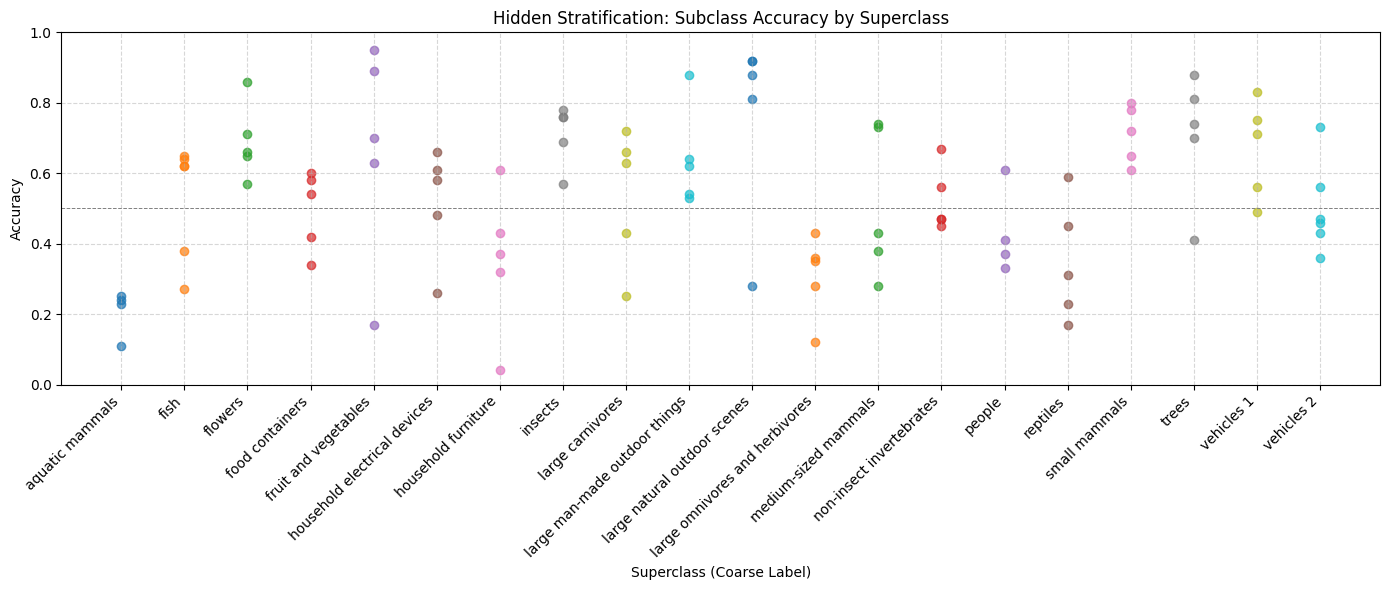

{'model': 'ResNeXt-29 8×64d',
 'schema_acc': 54.55,
 'mean_delta': 0.11592333333333334,
 'max_delta': 0.498,
 'min_delta': 0.0020000000000000018}

In [ ]:
#attempt at replicating the model used by original author
model_resnext = ResNeXt(
    cardinality=8,
    depth=29,
    bottleneck_width=64,
    num_classes=20
)

benchmark_model_variant_for_hidden_stratification_plot(
    model=model_resnext,
    model_name="ResNeXt-29 8×64d",
    trainloader=trainloader,
    testloader=testloader,
    device=device,
    fine_to_coarse=fine_to_coarse,
    coarse_label_names=coarse_label_names,
    epochs=25
)


🚀 Benchmarking ResNet-29 (No Groups)


<ipython-input-7-5adb358214e0>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/25:   0%|          | 0/782 [00:00<?, ?it/s]<ipython-input-7-5adb358214e0>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/25: 100%|██████████| 782/782 [00:52<00:00, 15.01it/s]
<ipython-input-7-5adb358214e0>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Acc: 16.21%
Test Acc: 20.56%
✔️ Best model saved.


Epoch 2/25: 100%|██████████| 782/782 [00:47<00:00, 16.49it/s]


Train Acc: 24.05%
Test Acc: 25.46%
✔️ Best model saved.


Epoch 3/25: 100%|██████████| 782/782 [00:47<00:00, 16.53it/s]


Train Acc: 28.53%
Test Acc: 29.34%
✔️ Best model saved.


Epoch 4/25: 100%|██████████| 782/782 [00:47<00:00, 16.49it/s]


Train Acc: 32.06%
Test Acc: 33.33%
✔️ Best model saved.


Epoch 5/25: 100%|██████████| 782/782 [00:47<00:00, 16.61it/s]


Train Acc: 36.36%
Test Acc: 37.15%
✔️ Best model saved.


Epoch 6/25: 100%|██████████| 782/782 [00:47<00:00, 16.56it/s]


Train Acc: 40.04%
Test Acc: 40.50%
✔️ Best model saved.


Epoch 7/25: 100%|██████████| 782/782 [00:48<00:00, 16.17it/s]


Train Acc: 43.46%
Test Acc: 40.65%
✔️ Best model saved.


Epoch 8/25: 100%|██████████| 782/782 [00:47<00:00, 16.50it/s]


Train Acc: 45.20%
Test Acc: 41.18%
✔️ Best model saved.


Epoch 9/25: 100%|██████████| 782/782 [00:47<00:00, 16.58it/s]


Train Acc: 46.56%
Test Acc: 40.07%


Epoch 10/25: 100%|██████████| 782/782 [00:46<00:00, 16.65it/s]


Train Acc: 47.36%
Test Acc: 43.65%
✔️ Best model saved.


Epoch 11/25: 100%|██████████| 782/782 [00:47<00:00, 16.52it/s]


Train Acc: 48.73%
Test Acc: 43.70%
✔️ Best model saved.


Epoch 12/25: 100%|██████████| 782/782 [00:47<00:00, 16.59it/s]


Train Acc: 49.25%
Test Acc: 40.17%


Epoch 13/25: 100%|██████████| 782/782 [00:47<00:00, 16.60it/s]


Train Acc: 49.97%
Test Acc: 43.83%
✔️ Best model saved.


Epoch 14/25: 100%|██████████| 782/782 [00:47<00:00, 16.50it/s]


Train Acc: 50.26%
Test Acc: 39.56%


Epoch 15/25: 100%|██████████| 782/782 [00:47<00:00, 16.39it/s]


Train Acc: 50.97%
Test Acc: 47.69%
✔️ Best model saved.


Epoch 16/25: 100%|██████████| 782/782 [00:47<00:00, 16.56it/s]


Train Acc: 50.68%
Test Acc: 46.59%


Epoch 17/25: 100%|██████████| 782/782 [00:47<00:00, 16.58it/s]


Train Acc: 51.39%
Test Acc: 41.78%


Epoch 18/25: 100%|██████████| 782/782 [00:46<00:00, 16.64it/s]


Train Acc: 51.88%
Test Acc: 46.05%


Epoch 19/25: 100%|██████████| 782/782 [00:47<00:00, 16.63it/s]


Train Acc: 51.96%
Test Acc: 47.82%
✔️ Best model saved.


Epoch 20/25: 100%|██████████| 782/782 [00:47<00:00, 16.44it/s]


Train Acc: 52.25%
Test Acc: 47.00%


Epoch 21/25: 100%|██████████| 782/782 [00:47<00:00, 16.59it/s]


Train Acc: 52.31%
Test Acc: 42.34%


Epoch 22/25: 100%|██████████| 782/782 [00:46<00:00, 16.72it/s]


Train Acc: 52.66%
Test Acc: 46.16%


Epoch 23/25: 100%|██████████| 782/782 [00:46<00:00, 16.73it/s]


Train Acc: 52.65%
Test Acc: 42.15%


Epoch 24/25: 100%|██████████| 782/782 [00:46<00:00, 16.71it/s]


Train Acc: 52.97%
Test Acc: 47.21%


Epoch 25/25: 100%|██████████| 782/782 [00:46<00:00, 16.94it/s]


Train Acc: 52.88%
Test Acc: 46.81%

=== Schema Completion (Hidden Stratification) ===
Superclass  0: Δacc range [-0.030, +0.040]
Superclass  1: Δacc range [-0.355, +0.305]
Superclass  2: Δacc range [-0.140, +0.080]
Superclass  3: Δacc range [-0.142, +0.118]
Superclass  4: Δacc range [-0.318, +0.292]
Superclass  5: Δacc range [-0.240, +0.210]
Superclass  6: Δacc range [-0.380, +0.290]
Superclass  7: Δacc range [-0.094, +0.096]
Superclass  8: Δacc range [-0.396, +0.184]
Superclass  9: Δacc range [-0.126, +0.144]
Superclass 10: Δacc range [-0.498, +0.132]
Superclass 11: Δacc range [-0.200, +0.080]
Superclass 12: Δacc range [-0.228, +0.262]
Superclass 13: Δacc range [-0.098, +0.192]
Superclass 14: Δacc range [-0.115, +0.075]
Superclass 15: Δacc range [-0.142, +0.468]
Superclass 16: Δacc range [-0.216, +0.314]
Superclass 17: Δacc range [-0.362, +0.328]
Superclass 18: Δacc range [-0.230, +0.120]
Superclass 19: Δacc range [-0.225, +0.425]

📊 Results for ResNet-29 (No Groups):
 - Schema Comple

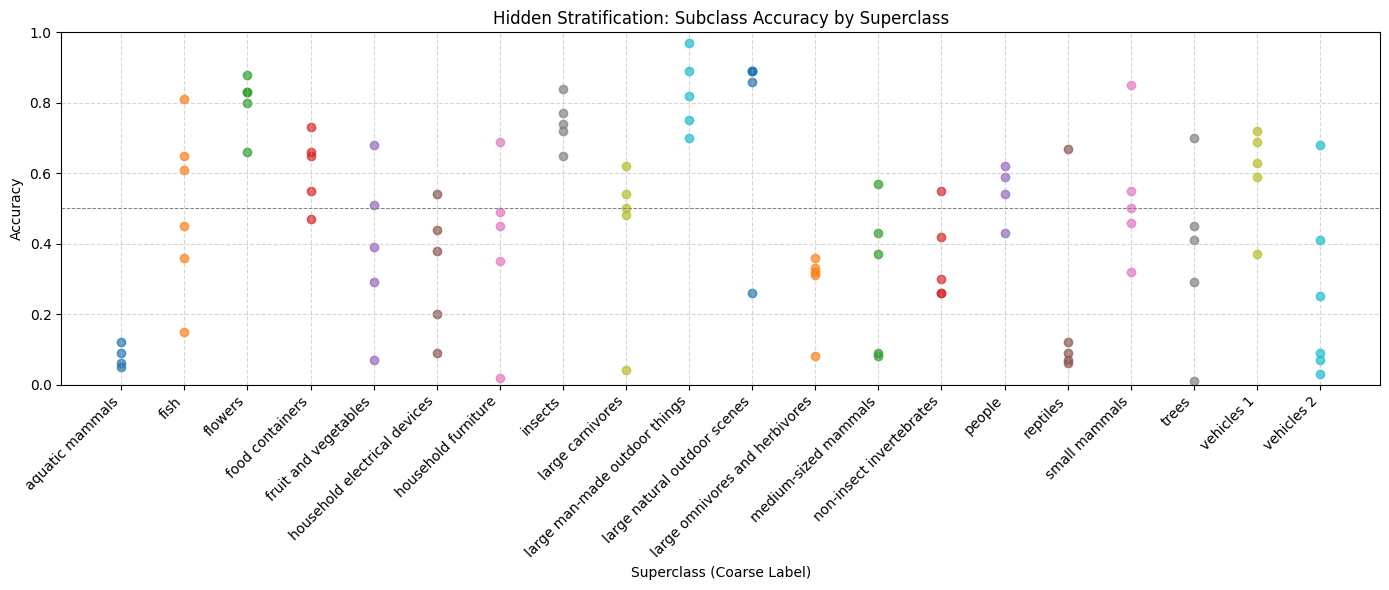

{'model': 'ResNet-29 (No Groups)',
 'schema_acc': 46.81,
 'mean_delta': 0.12938,
 'max_delta': 0.498,
 'min_delta': 0.0}

In [ ]:
#remove grouped convolutions as ablation to original report
model_resnet = ResNetVariant(
    depth=29,
    cardinality=1,
    bottleneck_width=64,
    num_classes=20,
    use_grouped=False  # disables grouped convolutions
)

benchmark_model_variant_for_hidden_stratification_plot(
    model=model_resnet,
    model_name="ResNet-29 (No Groups)",
    trainloader=trainloader,
    testloader=testloader,
    device=device,
    fine_to_coarse=fine_to_coarse,
    coarse_label_names=coarse_label_names,
    epochs=25
)

<ipython-input-8-4a9f26562980>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



🚀 Benchmarking ResNeXt-29 1×64d (Degenerate Grouping)


Epoch 1/25:   0%|          | 0/782 [00:00<?, ?it/s]<ipython-input-8-4a9f26562980>:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/25: 100%|██████████| 782/782 [00:46<00:00, 16.68it/s]
<ipython-input-8-4a9f26562980>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Acc: 17.37%
Test Acc: 22.54%
✔️ Best model saved.


Epoch 2/25: 100%|██████████| 782/782 [00:46<00:00, 16.93it/s]


Train Acc: 25.26%
Test Acc: 28.72%
✔️ Best model saved.


Epoch 3/25: 100%|██████████| 782/782 [00:45<00:00, 17.02it/s]


Train Acc: 30.59%
Test Acc: 31.24%
✔️ Best model saved.


Epoch 4/25: 100%|██████████| 782/782 [00:46<00:00, 16.84it/s]


Train Acc: 35.87%
Test Acc: 32.99%
✔️ Best model saved.


Epoch 5/25: 100%|██████████| 782/782 [00:46<00:00, 16.89it/s]


Train Acc: 40.95%
Test Acc: 37.65%
✔️ Best model saved.


Epoch 6/25: 100%|██████████| 782/782 [00:46<00:00, 16.89it/s]


Train Acc: 44.25%
Test Acc: 41.57%
✔️ Best model saved.


Epoch 7/25: 100%|██████████| 782/782 [00:46<00:00, 16.76it/s]


Train Acc: 45.93%
Test Acc: 42.20%
✔️ Best model saved.


Epoch 8/25: 100%|██████████| 782/782 [00:46<00:00, 16.93it/s]


Train Acc: 47.56%
Test Acc: 42.56%
✔️ Best model saved.


Epoch 9/25: 100%|██████████| 782/782 [00:46<00:00, 16.86it/s]


Train Acc: 48.77%
Test Acc: 44.24%
✔️ Best model saved.


Epoch 10/25: 100%|██████████| 782/782 [00:46<00:00, 16.96it/s]


Train Acc: 49.42%
Test Acc: 40.84%


Epoch 11/25: 100%|██████████| 782/782 [00:46<00:00, 16.98it/s]


Train Acc: 50.21%
Test Acc: 44.16%


Epoch 12/25: 100%|██████████| 782/782 [00:46<00:00, 16.85it/s]


Train Acc: 51.06%
Test Acc: 46.63%
✔️ Best model saved.


Epoch 13/25: 100%|██████████| 782/782 [00:46<00:00, 16.75it/s]


Train Acc: 51.34%
Test Acc: 45.72%


Epoch 14/25: 100%|██████████| 782/782 [00:46<00:00, 16.97it/s]


Train Acc: 52.02%
Test Acc: 46.49%


Epoch 15/25: 100%|██████████| 782/782 [00:46<00:00, 16.93it/s]


Train Acc: 52.74%
Test Acc: 43.29%


Epoch 16/25: 100%|██████████| 782/782 [00:46<00:00, 16.95it/s]


Train Acc: 52.55%
Test Acc: 46.97%
✔️ Best model saved.


Epoch 17/25: 100%|██████████| 782/782 [00:46<00:00, 16.96it/s]


Train Acc: 52.96%
Test Acc: 40.39%


Epoch 18/25: 100%|██████████| 782/782 [00:46<00:00, 16.72it/s]


Train Acc: 53.49%
Test Acc: 46.80%


Epoch 19/25: 100%|██████████| 782/782 [00:46<00:00, 16.84it/s]


Train Acc: 53.86%
Test Acc: 45.75%


Epoch 20/25: 100%|██████████| 782/782 [00:46<00:00, 16.87it/s]


Train Acc: 53.89%
Test Acc: 48.21%
✔️ Best model saved.


Epoch 21/25: 100%|██████████| 782/782 [00:46<00:00, 16.87it/s]


Train Acc: 54.10%
Test Acc: 45.19%


Epoch 22/25: 100%|██████████| 782/782 [00:46<00:00, 16.73it/s]


Train Acc: 54.50%
Test Acc: 43.61%


Epoch 23/25: 100%|██████████| 782/782 [00:46<00:00, 16.92it/s]


Train Acc: 54.78%
Test Acc: 50.45%
✔️ Best model saved.


Epoch 24/25: 100%|██████████| 782/782 [00:46<00:00, 16.81it/s]


Train Acc: 54.95%
Test Acc: 49.46%


Epoch 25/25: 100%|██████████| 782/782 [00:46<00:00, 16.92it/s]


Train Acc: 54.91%
Test Acc: 47.49%

=== Schema Completion (Hidden Stratification) ===
Superclass  0: Δacc range [-0.015, +0.025]
Superclass  1: Δacc range [-0.352, +0.218]
Superclass  2: Δacc range [-0.148, +0.142]
Superclass  3: Δacc range [-0.094, +0.086]
Superclass  4: Δacc range [-0.482, +0.268]
Superclass  5: Δacc range [-0.294, +0.176]
Superclass  6: Δacc range [-0.424, +0.356]
Superclass  7: Δacc range [-0.104, +0.066]
Superclass  8: Δacc range [-0.152, +0.148]
Superclass  9: Δacc range [-0.094, +0.116]
Superclass 10: Δacc range [-0.440, +0.160]
Superclass 11: Δacc range [-0.180, +0.180]
Superclass 12: Δacc range [-0.164, +0.246]
Superclass 13: Δacc range [-0.056, +0.154]
Superclass 14: Δacc range [-0.068, +0.042]
Superclass 15: Δacc range [-0.216, +0.644]
Superclass 16: Δacc range [-0.126, +0.284]
Superclass 17: Δacc range [-0.304, +0.196]
Superclass 18: Δacc range [-0.316, +0.174]
Superclass 19: Δacc range [-0.245, +0.195]

📊 Results for ResNeXt-29 1×64d (Degenerate Grouping):

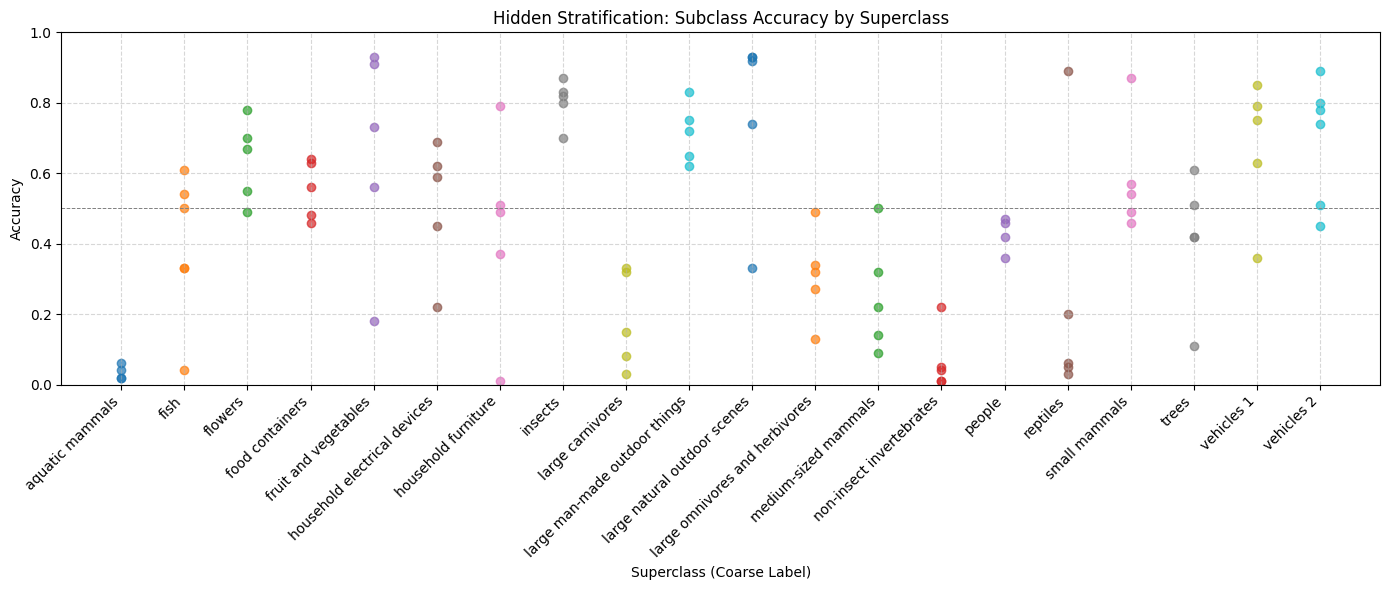

{'model': 'ResNeXt-29 1×64d (Degenerate Grouping)',
 'schema_acc': 47.49,
 'mean_delta': 0.12292000000000002,
 'max_delta': 0.644,
 'min_delta': 0.0040000000000000036}

In [ ]:
#reduce depth of cardinality as second ablation to original code
model_resnext_degenerate = ResNetVariant(
    depth=29,
    cardinality=1,
    bottleneck_width=64,
    num_classes=20,
    use_grouped=True  # grouped conv still on, but behaves like standard conv
)

benchmark_model_variant_for_hidden_stratification_plot(
    model=model_resnext_degenerate,
    model_name="ResNeXt-29 1×64d (Degenerate Grouping)",
    trainloader=trainloader,
    testloader=testloader,
    device=device,
    fine_to_coarse=fine_to_coarse,
    coarse_label_names=coarse_label_names,
    epochs=25
)